# Incremental Improvement

Code Written for the Shell.ai Hackathon 2020
Code generates a random arrangement of turbines, and incrementally modifies each turbine's position to constantly keep improving the AEP

Team Members:
* Omkar Nath
* Uma T.V.
* Mishma Mariyam Raju
* B. Bharatwaajan

Functions that are used for AEP calculation: 
* The preprocessing (wind data bin probability calculations) has been seprarated so as to save computation time.
* Algorithm used is exactly the same as the one provided
* There is an additional function deefined, getAEP1. This calculates AEP using only one average speed and direction. This was for the testing stages of the program, to same running time while developing the code
* getAEP540 uses the usual 540 bins

In [1]:
# Module List
import numpy  as np
import pandas as pd                     
from   math   import radians as DegToRad       # Degrees to radians Conversion

from shapely.geometry import Point             # Imported for constraint checking
from shapely.geometry.polygon import Polygon

import warnings
warnings.filterwarnings("ignore")

def binWindResourceData(df):
    """
    Loads the wind data. Returns a 2D array with shape (36,15). 
    Each cell in  array is a wind direction and speed 'instance'. 
    Values in a cell correspond to probability of instance
    occurence.  
    """
   
    # Load wind data. Then, extracts the 'drct', 'sped' columns
    wind_resource = df[['drct', 'sped']].to_numpy(dtype = np.float32)
    
    # direction 'slices' in degrees
    slices_drct   = np.roll(np.arange(10, 361, 10, dtype=np.float32), 1)
    ## slices_drct   = [360, 10.0, 20.0.......340, 350]
    n_slices_drct = slices_drct.shape[0]
    
    # speed 'slices'
    slices_sped   = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 
                        18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
    n_slices_sped = len(slices_sped)-1

    
    # placeholder for binned wind
    binned_wind = np.zeros((n_slices_drct, n_slices_sped), 
                           dtype = np.float32)
    
    # 'trap' data points inside the bins. 
    for i in range(n_slices_drct):
        for j in range(n_slices_sped):     
            
            # because we already have drct in the multiples of 10
            foo = wind_resource[(wind_resource[:,0] == slices_drct[i])] 

            foo = foo[(foo[:,1] >= slices_sped[j]) 
                          & (foo[:,1] <  slices_sped[j+1])]
            
            binned_wind[i,j] = foo.shape[0]  
    
    wind_inst_freq   = binned_wind/np.sum(binned_wind)
    wind_inst_freq   = wind_inst_freq.ravel()
    
    return(wind_inst_freq)

def searchSorted(lookup, sample_array):
    """"Returns lookup indices for closest values w.r.t sample_array elements"""

    lookup_middles = lookup[1:] - np.diff(lookup.astype('f'))/2
    idx1 = np.searchsorted(lookup_middles, sample_array)
    indices = np.arange(lookup.shape[0])[idx1]
    return indices

def preProcessing(power_curve):
    """
    Doing preprocessing to avoid the same repeating calculations.
    Record the required data for calculations. Do that once.
    Data are set up (shaped) to assist vectorization. Used later in
    function totalAEP. 
    """
    # number of turbines
    n_turbs       =   50
    
    # direction 'slices' in degrees
    slices_drct   = np.roll(np.arange(10, 361, 10, dtype=np.float32), 1)
    ## slices_drct   = [360, 10.0, 20.0.......340, 350]
    n_slices_drct = slices_drct.shape[0]
    
    # speed 'slices'
    slices_sped   = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 
                        18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
    n_slices_sped = len(slices_sped)-1
    
    # number of wind instances
    n_wind_instances = (n_slices_drct)*(n_slices_sped)
    
    # Create wind instances. There are two columns in the wind instance array
    # First Column - Wind Speed. Second Column - Wind Direction
    # Shape of wind_instances (n_wind_instances,2). 
    # Values [1.,360.],[3.,360.],[5.,360.]...[25.,350.],[27.,350.],29.,350.]
    wind_instances = np.zeros((n_wind_instances,2), dtype=np.float32)
    counter = 0
    for i in range(n_slices_drct):
        for j in range(n_slices_sped): 
            
            wind_drct =  slices_drct[i]
            wind_sped = (slices_sped[j] + slices_sped[j+1])/2
            
            wind_instances[counter,0] = wind_sped
            wind_instances[counter,1] = wind_drct
            counter += 1

	# So that the wind flow direction aligns with the +ve x-axis.			
    # Convert inflow wind direction from degrees to radians
    wind_drcts =  np.radians(wind_instances[:,1] - 90)
    # For coordinate transformation 
    cos_dir = np.cos(wind_drcts).reshape(n_wind_instances,1)
    sin_dir = np.sin(wind_drcts).reshape(n_wind_instances,1)
    
    # create copies of n_wind_instances wind speeds from wind_instances
    wind_sped_stacked = np.column_stack([wind_instances[:,0]]*n_turbs)
   
    # Pre-prepare matrix with stored thrust coeffecient C_t values for 
    # n_wind_instances shape (n_wind_instances, n_turbs, n_turbs). 
    # Value changing only along axis=0. C_t, thrust coeff. values for all 
    # speed instances.
    # we use power_curve data as look up to estimate the thrust coeff.
    # of the turbine for the corresponding closest matching wind speed
    indices = searchSorted(power_curve[:,0], wind_instances[:,0])
    C_t     = power_curve[indices,1]
    # stacking and reshaping to assist vectorization
    C_t     = np.column_stack([C_t]*(n_turbs*n_turbs))
    C_t     = C_t.reshape(n_wind_instances, n_turbs, n_turbs)
    
    return(n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)


    
def checkConstraints(turb_coords, turb_diam):
    """
    -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-
    
    Checks if the turbine configuration satisfies the two
    constraints:(i) perimeter constraint,(ii) proximity constraint 
    Prints which constraints are violated if any. Note that this 
    function does not quantifies the amount by which the constraints 
    are violated if any. 
    
    :called from
        main 
        
    :param
        turb_coords - 2d np array containing turbine x,y coordinates
        turb_diam   - Diameter of the turbine (m)
    
    :return
        None. Prints messages.   
    """
    bound_clrnc      = 50
    prox_constr_viol = False
    peri_constr_viol = False
    
    # create a shapely polygon object of the wind farm
    farm_peri = [(0, 0), (0, 4000), (4000, 4000), (4000, 0)]
    farm_poly = Polygon(farm_peri)
    
    # checks if for every turbine perimeter constraint is satisfied. 
    # breaks out if False anywhere
    for turb in turb_coords:
        turb = Point(turb)
        inside_farm   = farm_poly.contains(turb)
        correct_clrnc = farm_poly.boundary.distance(turb) >= bound_clrnc
        if (inside_farm == False or correct_clrnc == False):
            peri_constr_viol = True
            break
    
    # checks if for every turbines proximity constraint is satisfied. 
    # breaks out if False anywhere
    for i,turb1 in enumerate(turb_coords):
        for turb2 in np.delete(turb_coords, i, axis=0):
            if  np.linalg.norm(turb1 - turb2) < 4*turb_diam:
                prox_constr_viol = True
                break
    
    # print messages
    if  peri_constr_viol  == True  and prox_constr_viol == True:
          print('Somewhere both perimeter constraint and proximity constraint are violated\n')
    elif peri_constr_viol == True  and prox_constr_viol == False:
          print('Somewhere perimeter constraint is violated\n')
    elif peri_constr_viol == False and prox_constr_viol == True:
          print('Somewhere proximity constraint is violated\n')
    #else: print('Both perimeter and proximity constraints are satisfied !!\n')
        
    return()

# The function to calculate AEP using 540 bins, as in the code given to us
def getAEP540(turb_rad, turb_coords, power_curve, wind_inst_freq, 
            n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t):
    
    """
    Calculates AEP of the wind farm. Vectorised version.
    """
    # number of turbines
    n_turbs        =   turb_coords.shape[0]
    assert n_turbs ==  50, "Error! Number of turbines is not 50."
    
    # Prepare the rotated coordinates wrt the wind direction i.e downwind(x) & crosswind(y) 
    # coordinates wrt to the wind direction for each direction in wind_instances array
    rotate_coords   =  np.zeros((n_wind_instances, n_turbs, 2), dtype=np.float32)
    # Coordinate Transformation. Rotate coordinates to downwind, crosswind coordinates
    rotate_coords[:,:,0] =  np.matmul(cos_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) - \
                           np.matmul(sin_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
    rotate_coords[:,:,1] =  np.matmul(sin_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) +\
                           np.matmul(cos_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
 
    
    # x_dist - x dist between turbine pairs wrt downwind/crosswind coordinates)
    # for each wind instance
    x_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(n_wind_instances):
        tmp = rotate_coords[i,:,0].repeat(n_turbs).reshape(n_turbs, n_turbs)
        x_dist[i] = tmp - tmp.transpose()
    

    # y_dist - y dist between turbine pairs wrt downwind/crosswind coordinates)
    # for each wind instance    
    y_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(n_wind_instances):
        tmp = rotate_coords[i,:,1].repeat(n_turbs).reshape(n_turbs, n_turbs)
        y_dist[i] = tmp - tmp.transpose()
    y_dist = np.abs(y_dist) 
     

    # Now use element wise operations to calculate speed deficit.
    # kw, wake decay constant presetted to 0.05
    # use the jensen's model formula. 
    # no wake effect of turbine on itself. either j not an upstream or wake 
    # not happening on i because its outside of the wake region of j
    # For some values of x_dist here RuntimeWarning: divide by zero may occur
    # That occurs for negative x_dist. Those we anyway mark as zeros. 
    sped_deficit = (1-np.sqrt(1-C_t))*((turb_rad/(turb_rad + 0.05*x_dist))**2) 
    sped_deficit[((x_dist <= 0) | ((x_dist > 0) & (y_dist > (turb_rad + 0.05*x_dist))))] = 0.0
    
    
    # Calculate Total speed deficit from all upstream turbs, using sqrt of sum of sqrs
    sped_deficit_eff  = np.sqrt(np.sum(np.square(sped_deficit), axis = 2))

    
    # Element wise multiply the above with (1- sped_deficit_eff) to get
    # effective windspeed due to the happening wake
    wind_sped_eff     = wind_sped_stacked*(1.0-sped_deficit_eff)

    
    # Estimate power from power_curve look up for wind_sped_eff
    indices = searchSorted(power_curve[:,0], wind_sped_eff.ravel())
    power   = power_curve[indices,2]
    power   = power.reshape(n_wind_instances,n_turbs)
    
    # Farm power for single wind instance 
    power   = np.sum(power, axis=1)
    
    # multiply the respective values with the wind instance probabilities 
    # year_hours = 8760.0
    AEP = 8760.0*np.sum(power*wind_inst_freq)
    
    # Convert MWh to GWh
    AEP = AEP/1e3
    
    return(AEP)

# A specially defined function that calculates assuming only an average speed and direction
def getAEP1(turb_rad, turb_coords, power_curve):
    
    """
    Calculates AEP of the wind farm. Vectorised version.
    """
    
    theta = np.radians(225 - 90)
    cos_dir = np.array([[np.cos(theta)]])
    sin_dir = np.array([[np.sin(theta)]])
    n_wind_instances = 1
    C_t = np.array([[[0.80357]]])
    wind_sped_stacked = np.array([[8.9]])
    wind_inst_freq = np.array([1])
    
    # number of turbines
    n_turbs        =   turb_coords.shape[0]
    assert n_turbs ==  50, "Error! Number of turbines is not 50."
    
    # Prepare the rotated coordinates wrt the wind direction i.e downwind(x) & crosswind(y) 
    # coordinates wrt to the wind direction for each direction in wind_instances array
    rotate_coords   =  np.zeros((n_wind_instances, n_turbs, 2), dtype=np.float32)
    # Coordinate Transformation. Rotate coordinates to downwind, crosswind coordinates
    rotate_coords[:,:,0] =  np.matmul(cos_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) - \
                           np.matmul(sin_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
    rotate_coords[:,:,1] =  np.matmul(sin_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) +\
                           np.matmul(cos_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
 
    
    # x_dist - x dist between turbine pairs wrt downwind/crosswind coordinates)
    # for each wind instance
    x_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(n_wind_instances):
        tmp = rotate_coords[i,:,0].repeat(n_turbs).reshape(n_turbs, n_turbs)
        x_dist[i] = tmp - tmp.transpose()
    

    # y_dist - y dist between turbine pairs wrt downwind/crosswind coordinates)
    # for each wind instance    
    y_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(n_wind_instances):
        tmp = rotate_coords[i,:,1].repeat(n_turbs).reshape(n_turbs, n_turbs)
        y_dist[i] = tmp - tmp.transpose()
    y_dist = np.abs(y_dist) 
     

    # Now use element wise operations to calculate speed deficit.
    # kw, wake decay constant presetted to 0.05
    # use the jensen's model formula. 
    # no wake effect of turbine on itself. either j not an upstream or wake 
    # not happening on i because its outside of the wake region of j
    # For some values of x_dist here RuntimeWarning: divide by zero may occur
    # That occurs for negative x_dist. Those we anyway mark as zeros. 
    sped_deficit = (1-np.sqrt(1-C_t))*((turb_rad/(turb_rad + 0.05*x_dist))**2) 
    sped_deficit[((x_dist <= 0) | ((x_dist > 0) & (y_dist > (turb_rad + 0.05*x_dist))))] = 0.0
    
    
    # Calculate Total speed deficit from all upstream turbs, using sqrt of sum of sqrs
    sped_deficit_eff  = np.sqrt(np.sum(np.square(sped_deficit), axis = 2))

    
    # Element wise multiply the above with (1- sped_deficit_eff) to get
    # effective windspeed due to the happening wake
    wind_sped_eff     = wind_sped_stacked*(1.0-sped_deficit_eff)

    
    # Estimate power from power_curve look up for wind_sped_eff
    indices = searchSorted(power_curve[:,0], wind_sped_eff.ravel())
    power   = power_curve[indices,2]
    power   = power.reshape(n_wind_instances,n_turbs)
    
    # Farm power for single wind instance 
    power   = np.sum(power, axis=1)
    
    # multiply the respective values with the wind instance probabilities 
    # year_hours = 8760.0
    AEP = 8760.0*np.sum(power*wind_inst_freq)
    
    # Convert MWh to GWh
    AEP = AEP/1e3
    
    return(AEP)

### Preprocessing
Preprocessing of Wind Data is done here, to avoid repetive computation.

The "wind_data_combined.csv" file combines the wind data of all the years given for use

In [2]:
power_curve = pd.read_csv('power_curve.csv', sep=',', dtype = np.float32).to_numpy()
df_winddata = pd.read_csv('wind_data_combined.csv')

main_turb_specs    =  { 'Name': 'Anon Name', 'Vendor': 'Anon Vendor', 'Type': 'Anon Type', 'Dia (m)': 100, 'Rotor Area (m2)': 7853, 'Hub Height (m)': 100, 'Cut-in Wind Speed (m/s)': 3.5, 'Cut-out Wind Speed (m/s)': 25, 'Rated Wind Speed (m/s)': 15, 'Rated Power (MW)': 3 }
main_turb_diam      =  main_turb_specs['Dia (m)']
main_turb_rad       =  main_turb_diam/2 

main_wind_inst_freq =  binWindResourceData(df_winddata)  
main_n_wind_instances, main_cos_dir, main_sin_dir, main_wind_sped_stacked, main_C_t = preProcessing(power_curve)

### Functions
Following are the various functions used in the optimization code.

In [3]:
# Importing Libraries
import pandas as pd
import math
import random
import matplotlib.pyplot as plt

In [4]:
# Calculates distance between i turbine and coordinates (p,q)
def distance(df, i, p, q):
        x = df.iloc[i,0] - p
        y = df.iloc[i,1] - q
        dist = x**2 + y**2
        return (math.sqrt(dist))

In [5]:
# Check if the coordinates of the given turbine t satisfy all constraints
def isValid(df, t):
    if(not (df.x[t] <= 3950 and df.y[t] <= 3950 and df.x[t] >= 50 and df.y[t] >= 50)):
        return False
    
    x = df.x[t]
    y = df.y[t]
    for i in range(0,50):
        if((distance(df, i, x, y)) < 400 and (i!=t)):
            return False
    return True

In [6]:
# Generates a random valid arrangement of 50 turbines
def generateRandom(df):    
    x = random.randint(50, 3950)
    y = random.randint(50, 3950)
    df.iloc[0] = [x,y]
    for i in range(1,50):
        x = random.randint(50, 3950)
        y = random.randint(50, 3950)
        flag = 0
        while(flag == 0):
            flag = 1
            for j in range(0,i):
                if(distance(df, j, x, y) < 400):
                    flag = 0
                    break
            df.iloc[i] = [x,y]
            x = random.randint(50, 3950)
            y = random.randint(50, 3950)
    return(df)

In [7]:
# Generates "num_iter" number of random arrangements, and returns the one with the best AEP
def bestRandom(num_iter = 100):
    df_coords = pd.DataFrame(pd.read_csv("Grid.csv", dtype = np.float32)[["x","y"]])
    df_bestcoords = df_coords.copy()

    turb_coords = df_coords.to_numpy(dtype = np.float32)
    #maxAEP = getAEP1(main_turb_rad, turb_coords, power_curve)
    maxAEP = getAEP540(main_turb_rad, turb_coords, power_curve, main_wind_inst_freq, main_n_wind_instances, main_cos_dir, main_sin_dir, main_wind_sped_stacked, main_C_t) 

    for i in range(num_iter):
        df_coords = generateRandom(df_coords)   

        turb_coords = df_coords.to_numpy(dtype = np.float32)
        #currentAEP = getAEP1(main_turb_rad, turb_coords, power_curve)
        currentAEP = getAEP540(main_turb_rad, turb_coords, power_curve, main_wind_inst_freq, main_n_wind_instances, main_cos_dir, main_sin_dir, main_wind_sped_stacked, main_C_t) 

        #print(i,currentAEP)
        if(currentAEP>maxAEP):
            maxAEP = currentAEP
            df_bestcoords = df_coords.copy()
    
    return(df_bestcoords, maxAEP)

* The most important function. 
* It takes a configuration, and a distance. 
* It then tries to move every turbine in every direction by that specified ditance
* If upon movement, there is an improvement, the new configuration is saved. Then it tries that again\
* "num_iter" variable here controls the precision of the angles. 
* Example, 'num_iter = 3 implies every 10 degrees'; 'num_iter = 1 implies every 30 degrees'

In [8]:
# Trying to move every turbine in every direction by specified distance
def TurbineImprovement(df_coords_current, dist = 10.0):

    df_coords_new = df_coords_current.copy()

    #initial_AEP = getAEP1(main_turb_rad, df_coords_current.to_numpy(), power_curve)
    initial_AEP = getAEP540(main_turb_rad, df_coords_current.to_numpy(), power_curve, main_wind_inst_freq, main_n_wind_instances, main_cos_dir, main_sin_dir, main_wind_sped_stacked, main_C_t)

    theta_difference = 30
    thetas = np.arange(0, 361, theta_difference, dtype=np.float32)
    curr_AEP = initial_AEP
    changes = 0
    
    # This also determines the precision of the angle. 
    num_iter = 3

    for i in range(num_iter):
        
        for turbine in range(50):
            #print(turbine)
            for theta in thetas:

                # flag is used to keep trying to improve, while improvement is possible
                flag = True
                while(flag):

                    x = df_coords_current.x[turbine] + dist*np.cos(np.radians(theta + float(i)*theta_difference/num_iter))
                    y = df_coords_current.y[turbine] + dist*np.sin(np.radians(theta + float(i)*theta_difference/num_iter))
                    df_coords_new.iloc[turbine] = [x, y]

                    if(isValid(df_coords_new, turbine)):
                        turb_coords = df_coords_new.to_numpy()
                        #new_AEP = getAEP1(main_turb_rad, turb_coords, power_curve)
                        new_AEP = getAEP540(main_turb_rad, turb_coords, power_curve, main_wind_inst_freq, main_n_wind_instances, main_cos_dir, main_sin_dir, main_wind_sped_stacked, main_C_t)

                        if(new_AEP>curr_AEP):
                            df_coords_current.iloc[turbine] = [x, y]
                            changes += 1
                            curr_AEP = new_AEP
                        else:
                            flag = False
                    else:
                        flag = False

                    df_coords_new.iloc[turbine] = df_coords_current.iloc[turbine]

    return(df_coords_current, curr_AEP, initial_AEP, changes)

The original inspiration of the code. Though now not relevant.

In [9]:
# Randomly choosed a turbine and tries moving it
def RandomSearch(df_coords_current, num_iter = 1000, dist = 5.0):
    
    df_coords_new = df_coords_current.copy()

    #initial_AEP = getAEP1(main_turb_rad, df_coords_current.to_numpy(), power_curve)
    initial_AEP = getAEP540(main_turb_rad, df_coords_current.to_numpy(), power_curve, main_wind_inst_freq, main_n_wind_instances, main_cos_dir, main_sin_dir, main_wind_sped_stacked, main_C_t)

    flag = False
    turbine = 0
    theta = 0
    curr_AEP = initial_AEP
    changes = 0
    j = 0
    
    for i in range(num_iter):
        
        if(flag):
            x = df_coords_current.x[turbine] + dist*np.cos(np.radians(theta))
            y = df_coords_current.y[turbine] + dist*np.sin(np.radians(theta))
            df_coords_new.iloc[turbine] = [x, y]

            if(isValid(df_coords_new, turbine)):
                turb_coords = df_coords_new.to_numpy()
                #new_AEP = getAEP1(main_turb_rad, turb_coords, power_curve)
                new_AEP = getAEP540(main_turb_rad, turb_coords, power_curve, main_wind_inst_freq, main_n_wind_instances, main_cos_dir, main_sin_dir, main_wind_sped_stacked, main_C_t)

                if(new_AEP>curr_AEP):
                    df_coords_current.iloc[turbine] = [x, y]
                    changes += 1
                    curr_AEP = new_AEP
                    flag = True
                else:
                    flag = False
            else:
                flag = False

            df_coords_new.iloc[turbine] = df_coords_current.iloc[turbine]

        else:
            turbine = random.randint(0, 49)
            theta = random.randint(0, 360)

            x = df_coords_current.x[turbine] + dist*np.cos(np.radians(theta))
            y = df_coords_current.y[turbine] + dist*np.sin(np.radians(theta))
            df_coords_new.iloc[turbine] = [x, y]

            if(isValid(df_coords_new, turbine)):
                turb_coords = df_coords_new.to_numpy()
                #new_AEP = getAEP1(main_turb_rad, turb_coords, power_curve)
                new_AEP = getAEP540(main_turb_rad, turb_coords, power_curve, main_wind_inst_freq, main_n_wind_instances, main_cos_dir, main_sin_dir, main_wind_sped_stacked, main_C_t)

                if(new_AEP>curr_AEP):
                    df_coords_current.iloc[turbine] = [x, y]
                    changes += 1
                    curr_AEP = new_AEP
                    flag = True
                else:
                    flag = False
            else:
                flag = False
            
            df_coords_current.iloc[turbine] = df_coords_current.iloc[turbine]

    return(df_coords_current, curr_AEP, initial_AEP, changes)

In [10]:
# Function to visualize the turbines
def visualizeTurbines(df):
    plt.figure(figsize = (6,5))
    plt.scatter(df.x, df.y)
    plt.title("Scatter plot")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

### The main Code
The code basically calls turbineImprovment function over a range of distances, going from large to small.

In [11]:
# A more elaborate alternative for the number of steps. Used for really fine tuning the result.
steps = []
for i in reversed(range(3400,4000,100)):  steps.append(i)
for i in reversed(range(2600,3400,80)):  steps.append(i)
for i in reversed(range(2000,2600,60)):  steps.append(i)
for i in reversed(range(1400,2000,50)):  steps.append(i)
for i in reversed(range(1000,1400,40)):  steps.append(i)
for i in reversed(range(850,1000,30)):  steps.append(i)
for i in reversed(range(350,850,25)):  steps.append(i)
for i in reversed(range(200,350,15)):  steps.append(i)
for i in reversed(range(100,200,10)):  steps.append(i)
for i in reversed(range(70,100,5)):  steps.append(i)
for i in reversed(range(30,70,4)):  steps.append(i)
for i in reversed(range(10,30,2)):  steps.append(i)
for i in reversed(range(1,10,1)):  steps.append(i)
print(len(steps))

128


In [12]:
# Various step size options are available. The more the steps, the better the results
# These step sizes have been chosen as the optimal after much analysis

num_iter = 1  # Number of configs to improve
num_loop = 1   # Number of times to run each step

#steps = [3600.0, 3200.0, 2800.0, 2400.0, 2200.0, 2000.0, 1800.0, 1600.0, 1400.0, 1200.0, 1000.0, 900.0, 800.0, 700.0, 600.0, 500.0, 400.0, 300.0, 250.0, 200.0, 160.0, 125.0, 100.0, 80.0, 65.0, 45.0, 30.0, 15.0, 7.0, 3.0, 1.0]
steps = [700.0, 600.0, 500.0, 400.0, 300.0, 250.0, 200.0, 160.0, 135.0, 100.0, 88.0, 66.0, 48.0, 40.0, 34.0, 24.0, 16.0, 12.0, 9.0, 7.0, 5.0, 3.0, 2.0, 1.0]
#steps = [200.0, 120.0, 80.0 ,50.0 ,30.0, 15.0, 7.0, 4.0, 2.0]

for i in range(num_iter):
    
    df_coords, maxAEP  = bestRandom(20)        # Using random config
    #df_coords = df_bestcoords.copy()            # Using previous best config
    #df_coords = pd.read_csv("Grid v2.5.csv")   # Using a file config
    
    df_bestcoords = df_coords.copy()
    
    #maxAEP = getAEP1(main_turb_rad, df_coords.to_numpy(), power_curve)
    startAEP = getAEP540(main_turb_rad, df_coords.to_numpy(), power_curve, main_wind_inst_freq, main_n_wind_instances, main_cos_dir, main_sin_dir, main_wind_sped_stacked, main_C_t)
    maxAEP = startAEP

    print("Iteration {}".format(i))
    print("\nInitial AEP: {}\n".format(maxAEP))
    
    for step in steps:
        status = True
        while(status):
            status = False
            df_coords, currentAEP, initialAEP, changes = TurbineImprovement(df_coords, step)

            print("Step: {} \tCurrent: AEP {:.4f} \tAEP Diff: {:.4f} Improvements: {}".format(step, currentAEP, (currentAEP-initialAEP), changes))
          
            if(changes>0):
                status = False
                #status = True
                #Uncommenting this will mean that the same step size will keep running as long as improvements are possible
                
            if(currentAEP>maxAEP):
                maxAEP = currentAEP
                df_bestcoords = df_coords.copy()
            
            df_bestcoords.to_csv("Coorindates{}.csv".format(i), index=False)
        
    print("\nBest AEP: {}\n".format(maxAEP))
    print("Actual AEP by Website standards (approx): {}".format(maxAEP+19.4))
    print("Improvement in AEP: {}\n\n".format((maxAEP-startAEP)))

Iteration 0

Initial AEP: 506.25965606689454

Step: 700.0 	Current: AEP 510.6016 	AEP Diff: 4.3420 Improvements: 21
Step: 600.0 	Current: AEP 512.4940 	AEP Diff: 1.8923 Improvements: 13
Step: 500.0 	Current: AEP 514.3299 	AEP Diff: 1.8360 Improvements: 17
Step: 400.0 	Current: AEP 517.0724 	AEP Diff: 2.7425 Improvements: 19
Step: 300.0 	Current: AEP 518.8951 	AEP Diff: 1.8226 Improvements: 18
Step: 250.0 	Current: AEP 519.9608 	AEP Diff: 1.0657 Improvements: 10
Step: 200.0 	Current: AEP 520.8702 	AEP Diff: 0.9094 Improvements: 13
Step: 160.0 	Current: AEP 521.7269 	AEP Diff: 0.8567 Improvements: 10
Step: 135.0 	Current: AEP 522.1011 	AEP Diff: 0.3742 Improvements: 11
Step: 100.0 	Current: AEP 522.9041 	AEP Diff: 0.8030 Improvements: 19
Step: 88.0 	Current: AEP 523.6286 	AEP Diff: 0.7245 Improvements: 15
Step: 66.0 	Current: AEP 523.9007 	AEP Diff: 0.2721 Improvements: 7
Step: 48.0 	Current: AEP 524.0915 	AEP Diff: 0.1907 Improvements: 5
Step: 40.0 	Current: AEP 524.4156 	AEP Diff: 0.32

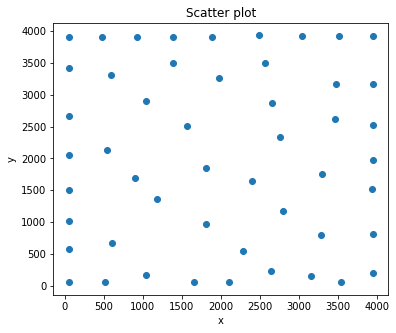

In [13]:
# Visualizing the best result
visualizeTurbines(df_bestcoords)